In [403]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import svm, feature_selection, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [404]:
def markOutliers(df,columns):

    t = np.zeros(df.shape[0])
    z = np.zeros(df.shape[0])
    for column in columns:
        mean=np.mean(df[column])
        sd=np.std(df[column])
        threshold=2
        test=[]

        for i, x in enumerate(df[column]):
            if column=="SALE_PRICE":
                if x<10000:
                    t[i]=1
            z[i]=(x-mean)/sd
            if z[i]>=threshold:
                test.append((x,z[i]))
                t[i]=1
        print(column,'\n', test)
    df['outlier']=t
    
    return df

In [405]:
def fillNeighborhood(df):
    zip_to_neigh={}
    for i,r in df.iterrows():
        if  not pd.isnull(r["NEIGHBORHOOD"]) and not pd.isnull(r["ZIP_CODE"]):
            zip_to_neigh[r["ZIP_CODE"]] = r["NEIGHBORHOOD"]
    for i,r in df.iterrows():
        if  pd.isnull(r["NEIGHBORHOOD"]) and not pd.isnull(r["ZIP_CODE"]):
            r["NEIGHBORHOOD"]=zip_to_neigh[r["ZIP_CODE"]]
    return df

In [406]:
def checkUnits(df):
    t = np.zeros(df.shape[0])
    for i, r in df.iterrows():
        if pd.isnull(r["RESIDENTIAL_UNITS"]) and pd.isnull(r["COMMERCIAL_UNITS"]): #and pd.isnull(r["TOTAL_UNITS"]):
            t[i]=1
    df['no_units']=t
    return df

def fillUnits(df):
    df[["RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS"]]=df[["RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS"]].replace(np.NaN, 0)
    count=0
    for i, r in df.iterrows():
        if r["RESIDENTIAL_UNITS"]+r["COMMERCIAL_UNITS"]!=r["TOTAL_UNITS"] and r["RESIDENTIAL_UNITS"]+r["COMMERCIAL_UNITS"]!=0:
            print(r["TOTAL_UNITS"],r["RESIDENTIAL_UNITS"],r["COMMERCIAL_UNITS"])
            r["TOTAL_UNITS"]=r["RESIDENTIAL_UNITS"]+r["COMMERCIAL_UNITS"]
    return df["TOTAL_UNITS"]



In [407]:
def step2_clean_1():
    df = pd.read_csv("Manhattan12.csv")

    # Print shape
    print(df.shape)

    # Rename incorrect column names
    df.rename(columns={"APART\r\nMENT\r\nNUMBER":"APARTMENT NUMBER", "SALE\r\nPRICE":"SALE PRICE"}, inplace = True)
    numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
    categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'
    ]
    df.columns=df.columns.str.replace(' ', '_')
    # df_num_man=df.filter(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE']).copy()

    #num_cols=pd.concat([num_cols,df_num_man], axis=1, join='inner')
    df[numerical]=df[numerical].replace('\$','', regex=True)
    df[numerical]=df[numerical].replace(',','', regex=True)


    df['SALE_DATE']=pd.to_datetime(df['SALE_DATE'], dayfirst=True)
    df[categorical]=df[categorical].replace(' ', '', regex=True)
    df[categorical]=df[categorical].replace('', np.NaN)

    df[numerical]=df[numerical].apply(pd.to_numeric)
    df[numerical]=df[numerical].replace(0, np.NaN)
    df.drop_duplicates(inplace=True)
    df.dropna(subset=["NEIGHBORHOOD"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT_NUMBER'], inplace=True)
    df=markOutliers(df, numerical)
    df=df[df.outlier==0]
    df=df.drop('outlier', axis=1)
    df.reset_index(drop=True, inplace=True)

    df[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]]=df[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET", "SALE_PRICE"]].interpolate()

    return df

In [408]:
def convertNeighborhood(df):
    m = np.zeros(df.shape[0])
    dfgroup=df.groupby(by="NEIGHBORHOOD", as_index=False).mean()
    #df.groupby(by="NEIGHBORHOOD", as_index=False).mean().to_csv('groupednorm.csv')
    print(dfgroup)
    
    n=np.zeros(dfgroup.shape[0])
    for i, r in dfgroup.iterrows():
        if r["SALE_PRICE"]<.12:
            n[i]=1
        elif r["SALE_PRICE"]>.15:
            n[i]=3
        else:
            n[i]=2
    dfgroup['NCat']=n
    for i, r in df.iterrows():
        temp = dfgroup[dfgroup["NEIGHBORHOOD"]==r["NEIGHBORHOOD"]]["NCat"]
        m[i]=temp

    return m

def normalize(df,num_cols):
    df_norm=df.copy()
    df_norm[num_cols]=df_norm[num_cols]/df_norm[num_cols].abs().max()
    return df_norm

(27395, 21)
RESIDENTIAL_UNITS 
 [(61.0, 2.4180911949706263), (59.0, 2.332671637017646), (68.0, 2.7170596478060576), (134.0, 5.535905060254407), (162.0, 6.7317788715961315), (180.0, 7.500554893172954), (133.0, 5.4931952812779175), (65.0, 2.588930310876587), (56.0, 2.2045423000881756), (56.0, 2.2045423000881756), (538.0, 22.79065576675643), (66.0, 2.6316400898530774), (66.0, 2.6316400898530774), (255.0, 10.703788316409716), (157.0, 6.518229976713681), (91.0, 3.699384564265331), (55.0, 2.1618325211116853), (70.0, 2.8024792057590378), (54.0, 2.1191227421351955), (92.0, 3.7420943432418214), (85.0, 3.44312589040639), (52.0, 2.033703184182215), (90.0, 3.656674785288841), (85.0, 3.44312589040639), (85.0, 3.44312589040639), (117.0, 4.809838817654075), (123.0, 5.066097491513016), (84.0, 3.4004161114299), (522.0, 22.10729930313259), (63.0, 2.503510752923607), (89.0, 3.613965006312351), (59.0, 2.332671637017646), (53.0, 2.076412963158705), (62.0, 2.4608009739471166), (62.0, 2.4608009739471166), (6

C:\Users\zacha\AppData\Local\Temp\ipykernel_5764\2447460760.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfgroup=df.groupby(by="NEIGHBORHOOD", as_index=False).mean()


                NEIGHBORHOOD        BLOCK          LOT      ZIP_CODE  \
0               ALPHABETCITY   391.931034   373.303448  10008.475862   
1                    CHELSEA   755.632899   725.388164  10008.866600   
2                  CHINATOWN   222.042424   930.503030  10012.393939   
3                CIVICCENTER   149.574468   960.344681  10011.451064   
4                    CLINTON  1063.131474   900.657371  10029.633466   
5                EASTVILLAGE   450.713592   400.330097  10004.776699   
6                    FASHION   815.943128   597.701422  10010.748815   
7                  FINANCIAL    45.103239  1159.953441  10014.526316   
8                   FLATIRON   839.535294   961.180392  10009.472549   
9                   GRAMERCY   887.408745   274.674905  10006.823194   
10  GREENWICHVILLAGE-CENTRAL   554.213026   454.027137  10007.567164   
11     GREENWICHVILLAGE-WEST   612.593123   507.846705  10013.477077   
12            HARLEM-CENTRAL  1877.583007   605.426144  10029.60

C:\Users\zacha\AppData\Local\Temp\ipykernel_5764\1948479898.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)


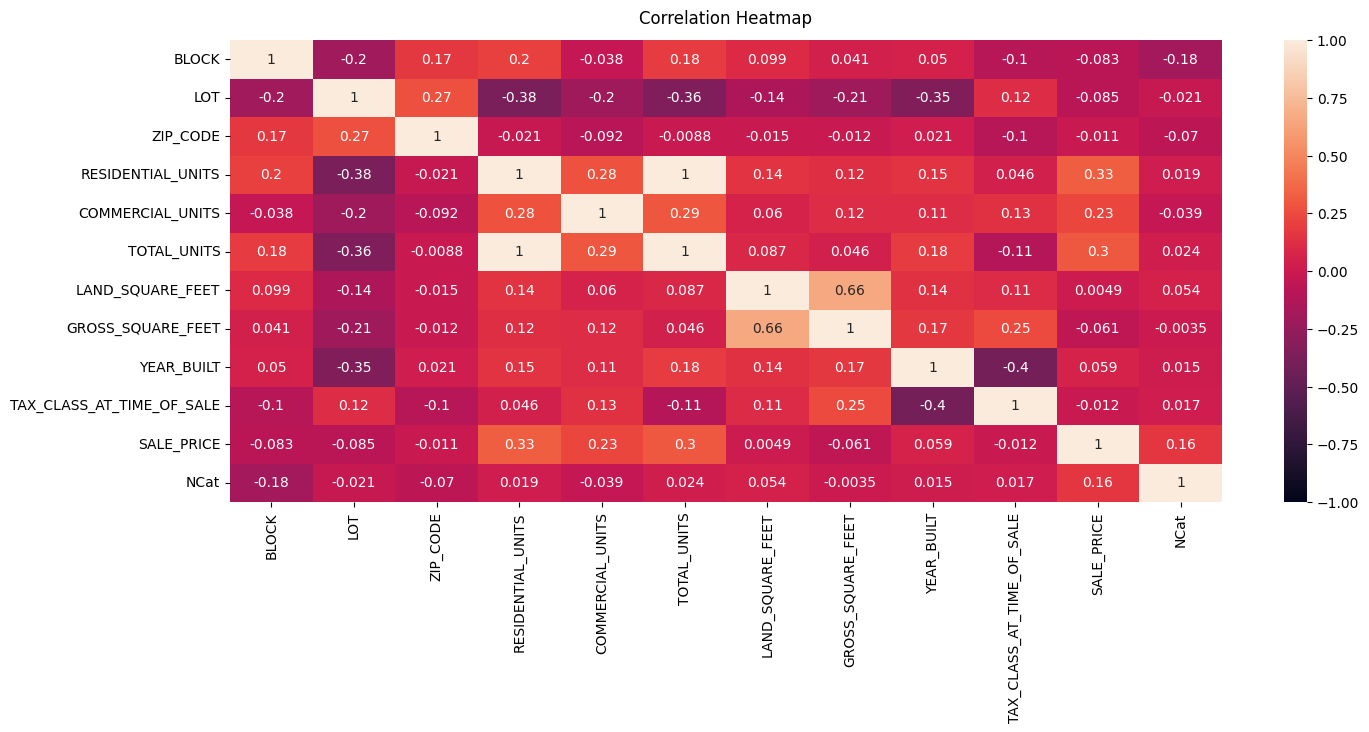

In [409]:
numerical=['RESIDENTIAL_UNITS','COMMERCIAL_UNITS','TOTAL_UNITS','LAND_SQUARE_FEET','GROSS_SQUARE_FEET','SALE_PRICE']
categorical=['BOROUGH','NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK','LOT','EASE-MENT', 'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER','ZIP_CODE','YEAR_BUILT','TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']
df=step2_clean_1()

df=normalize(df,numerical)
df["NCat"]=convertNeighborhood(df)
print(df.shape)
print(df.isnull().sum())
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

In [388]:
# df=checkUnits(df)
# df=df[df.no_units==0]
# df=df.drop('no_units', axis=1)
# df.reset_index(drop=True, inplace=True)
# print(df.shape)
# print(df.isnull().sum())

In [389]:


# df[numerical]=df[numerical].replace(np.NaN, 0)
# df["TOTAL_UNITS"]=fillUnits(df)
# df[numerical]=df[numerical].replace(0,np.NaN)
# print(df.shape)
# print(df.isnull().sum())

In [390]:
# def cleanSquareFt(df):
#     dfIncomplete=df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET"]].copy()
#     dfComplete=df[["LAND_SQUARE_FEET","GROSS_SQUARE_FEET","RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS","TAX_CLASS_AT_TIME_OF_SALE"]].copy()
#     dfComplete=dfComplete.replace(np.NaN, 0)
#     dfComplete[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET"]]=dfComplete[["LAND_SQUARE_FEET", "GROSS_SQUARE_FEET"]].replace(0,np.NaN)
#     dfComplete.dropna(inplace=True)
#     print("complete", dfComplete.shape)

#     feature_col=["LAND_SQUARE_FEET","RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS","TAX_CLASS_AT_TIME_OF_SALE"]
#     XO=dfComplete[["LAND_SQUARE_FEET","RESIDENTIAL_UNITS", "COMMERCIAL_UNITS", "TOTAL_UNITS","TAX_CLASS_AT_TIME_OF_SALE"]]
#     YO=dfComplete['GROSS_SQUARE_FEET']
#     est=svm.SVR(kernel="linear")
#     sel= feature_selection.RFE(est, n_features_to_select=6, step=1)
#     sel = sel.fit(XO, YO)
#     select_features = np.array(feature_col)[sel.ranking_==1].tolist()
#     print(select_features)
#     #X = df[select_features]
#     #Define feature matrix X and target variable y
#     X = dfComplete[select_features]
#     y = dfComplete["GROSS_SQUARE_FEET"]

#     # Split data into training and test sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#     # Train a linear regression model
#     model = linear_model.LinearRegression()
#     model.fit(X_train, y_train)

#     # Evaluate the model on the testing data
#     score = model.score(X_test, y_test)
#     print("R^2 score:", score)

In [391]:
# cleanSquareFt(df)

In [410]:

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfnorm.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

NameError: name 'dfnorm' is not defined

<Figure size 1600x600 with 0 Axes>

In [393]:
print(df.head())
print(df.shape)

   NEIGHBORHOOD     BUILDING_CLASS_CATEGORY TAX_CLASS_AT_PRESENT  BLOCK   LOT  \
0  ALPHABETCITY                         NaN                    4    384  1401   
1  ALPHABETCITY          03THREEFAMILYHOMES                    1    377    66   
2  ALPHABETCITY           04TAXCLASS1CONDOS                   1C    399  1102   
3  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                   2B    374     1   
4  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                    2    375    62   

  BUILDING_CLASS_AT_PRESENT           ADDRESS  ZIP_CODE  RESIDENTIAL_UNITS  \
0                        RK  229EAST2NDSTREET     10009                NaN   
1                        C0  243EAST7THSTREET     10009           0.068182   
2                        R6  238EAST4THSTREET     10009           0.022727   
3                        C7  303EAST4THSTREET     10009           0.181818   
4                        C4  715EAST5THSTREET     10009           0.454545   

   COMMERCIAL_UNITS  TOTAL_UNITS  LAND_SQUAR

In [397]:
df[numerical]=df[numerical].replace(np.NaN, 0)
df.isnull().sum()

NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY           2642
TAX_CLASS_AT_PRESENT               121
BLOCK                                0
LOT                                  0
BUILDING_CLASS_AT_PRESENT          121
ADDRESS                              0
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
NCat                                 0
dtype: int64

Root Mean Squared Error: 0.07
Cross-validation scores:  [ 0.1689974   0.13119393 -0.41914899  0.07893027  0.0248973 ]
Mean cross-validation score: -0.00
Y-axis intercept 0.0485
Weight coefficients:
    RESIDENTIAL_UNITS: 1.0702
     COMMERCIAL_UNITS: 1.4791
          TOTAL_UNITS: -0.8755
     LAND_SQUARE_FEET: 0.0660
    GROSS_SQUARE_FEET: -0.2111
           YEAR_BUILT: -0.0000
         NEIGHBORHOOD: -0.0219
R squared for the training data is 0.239
Score against test data: 0.251


<AxesSubplot: xlabel='SALE_PRICE', ylabel='Count'>

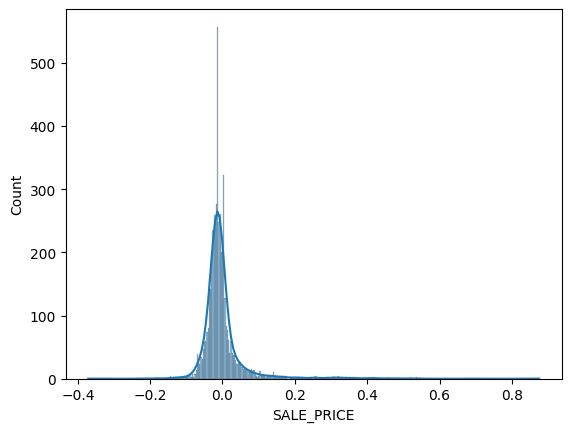

In [402]:
select_features=['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
        'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'NEIGHBORHOOD']
# Select predictors
X = df[select_features]

# Encode categorical variables using one-hot encoding
X = pd.get_dummies(X)

# Target variable
y = df['SALE_PRICE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: {:.2f}".format(rmse))

# Evaluate the model using cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: {:.2f}".format(np.mean(cv_scores)))

print("Y-axis intercept {:6.4f}".format(model.intercept_))
print("Weight coefficients:")
for feat, coef in zip(select_features, model.coef_):
    print(" {:>20}: {:6.4f}".format(feat, coef))
# The value of R^2
print("R squared for the training data is {:4.3f}".format(model.score(X_train,
y_train)))
print("Score against test data: {:4.3f}".format(model.score(X_test, y_test)))

# Plot histogram of residuals
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)